remove white space on plotly objects  
ask dr.clark about proper plotting


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
# set plot width here
plt.rcParams['figure.figsize'] = (15, 10)
from functions import import_data, my_plot_function

today = pd.to_datetime('today').strftime('%Y-%m-%d')

tickers = ['^VIX','^VIX3M', 'VXX']

VIX = import_data(tickers[0], '2018-01-01', today, '1d')
VIX3M = import_data(tickers[1], '2018-01-01', today, '1d')
VXX = import_data(tickers[2], '2018-01-01', today, '1d')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


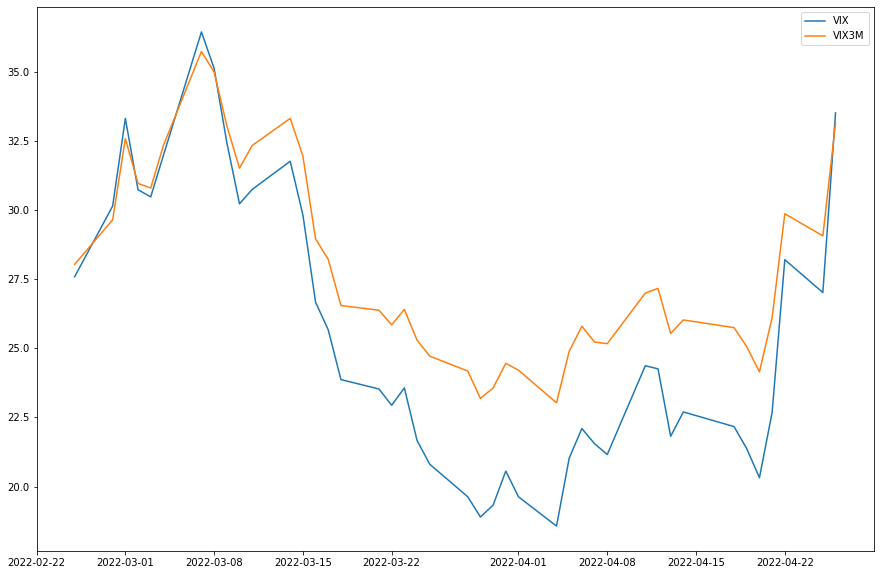

In [2]:
# plot vix and vix3m for the past month
plt.plot(VIX[-42:].index, VIX[-42:]['Close'], label='VIX')
plt.plot(VIX3M[-42:].index, VIX3M[-42:]['Close'], label='VIX3M')
plt.legend()
plt.show()



In [3]:
# repeat above cell with plotly for interactive plotting
import plotly.graph_objects as go
plot = go.Figure()
plot.add_trace(go.Line(x=VIX[-42:].index, y=VIX[-42:]['Close'], name='VIX'))
plot.add_trace(go.Line(x=VIX3M[-42:].index, y=VIX3M[-42:]['Close'], name='VIX3M'))
plot.show()


C:\Users\S\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




## The above shows that our most recent flip was correct

put in image from realtest

In [4]:
# housekeeping to combine dataframes later

df_master = pd.DataFrame(index=VIX.index)
df_master['VXX'] = VXX['Close'].round(2)
df_master['VIX'] = VIX['Close'].round(2)
df_master['VIX3M'] = VIX3M['Close'].round(2)
df_master['Contango'] = df_master['VIX'] < df_master['VIX3M']
df_master.tail(10)


,VXX,VIX,VIX3M,Contango
Date,,,,
2022-04-12,25.74,24.26,27.17,True
2022-04-13,24.59,21.82,25.54,True
2022-04-14,24.99,22.70,26.03,True
2022-04-18,25.31,22.17,25.75,True
2022-04-19,24.73,21.37,25.06,True
2022-04-20,24.39,20.32,24.15,True
2022-04-21,24.86,22.68,26.11,True
2022-04-22,26.15,28.21,29.87,True
2022-04-25,24.80,27.02,29.07,True



* NOTE:  Remove the rounding in production code.

In [5]:
df_master.tail(21)

,VXX,VIX,VIX3M,Contango
Date,,,,
2022-03-28,25.73,19.63,24.18,True
2022-03-29,24.85,18.90,23.19,True
2022-03-30,25.00,19.33,23.57,True
2022-03-31,25.70,20.56,24.46,True
2022-04-01,25.03,19.63,24.21,True
2022-04-04,24.43,18.57,23.03,True
2022-04-05,24.81,21.03,24.90,True
2022-04-06,24.38,22.10,25.80,True
2022-04-07,24.05,21.55,25.23,True


In [6]:
df = pd.read_csv('vxx_xl.csv')
# housekeeping
df.drop(['symbol'], inplace=True, axis=1)
# add - to date, exdate, and last date after 4 characters
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')
df['exdate'] = pd.to_datetime(df['exdate'].astype(str), format='%Y%m%d')
df['last_date'] = pd.to_datetime(df['last_date'].astype(str), format='%Y%m%d')
df = df[df['volume'] != 0]
# strike price is 100x too large
df['strike_price'] = df['strike_price'] / 1000

# Thank you to Bruce for the following code snippet.
# In short: never iterate through the dataframe if you can avoid it.
# Use a built in function or vectorize if possible.

df_combined = pd.DataFrame()
df_combined = df.merge(df_master, how = 'left', left_on = 'date', right_on = 'Date')
df_combined.tail(20)

FileNotFoundError: [Errno 2] No such file or directory: 'vxx_xl.csv'

In [8]:
# df_combined = pd.read_csv('df_combined.csv')

# How many NaN values are in the dataframe
print(len(df_combined))
df_combined.isna().sum()


58827


Unnamed: 0         0
secid              0
date               0
exdate             0
last_date          0
cp_flag            0
strike_price       0
best_bid           0
best_offer         0
volume             0
open_interest      0
impl_volatility    0
delta              0
gamma              0
vega               0
theta              0
optionid           0
ticker             0
index_flag         0
issuer             0
exercise_style     0
VXX                0
VIX                0
VIX3M              0
Contango           0
TTM                0
dtype: int64

Perhaps this is because of.... low volume?  Let's clean up strike so that we only have strike within 20% of VXX

In [9]:
df_combined = df_combined.where(df_combined['strike_price'] < df_combined['VXX']*1.2).dropna()
df_combined = df_combined.where(df_combined['strike_price'] > df_combined['VXX']*0.8).dropna()
print(len(df_combined))
# The 17 here is to only have the same option expiry date
df_combined.tail(17)

58827


,Unnamed: 0,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,...,optionid,ticker,index_flag,issuer,exercise_style,VXX,VIX,VIX3M,Contango,TTM
58810,721121,212622.0,2021-12-31,2022-06-17,2021-12-31,P,21.0,7.35,7.45,36.0,...,143148919.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,168
58811,721122,212622.0,2021-12-31,2022-06-17,2021-12-31,P,22.0,8.20,8.25,273.0,...,143148920.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,168
58812,721160,212622.0,2021-12-31,2022-11-18,2021-12-31,C,17.0,7.40,7.55,5.0,...,142044018.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,322
58813,721161,212622.0,2021-12-31,2022-11-18,2021-12-31,C,18.0,7.15,7.30,7.0,...,142044019.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,322
58814,721162,212622.0,2021-12-31,2022-11-18,2021-12-31,C,20.0,6.80,6.95,15.0,...,142044021.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,322
58815,721165,212622.0,2021-12-31,2022-11-18,2021-12-31,P,17.0,6.35,6.45,2.0,...,142044029.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,322
58816,721166,212622.0,2021-12-31,2022-11-18,2021-12-31,P,18.0,7.15,7.25,1.0,...,142044030.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,322
58817,721167,212622.0,2021-12-31,2022-11-18,2021-12-31,P,22.0,10.30,10.60,14.0,...,142044034.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,322
58818,721171,212622.0,2021-12-31,2023-01-20,2021-12-31,C,15.0,8.35,8.55,17.0,...,140006586.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,385
58819,721172,212622.0,2021-12-31,2023-01-20,2021-12-31,C,20.0,7.30,7.50,99.0,...,140006587.0,VXX,0.0,BARCLAYS BANK PLC,A,18.53,17.22,21.88,True,385


We have reduced from 233018 rows down to 36218 rows.

In [10]:
print(df.cp_flag.value_counts())

NameError: name 'df' is not defined

## NEED TO FIX HERE, SO THAT WE ONLY HAVE ONE EXPIRATION

In [ ]:
df = df_combined
df

The above is probably a relatively calm set of options.  The week between Christmas and New Year's is typically low volume.  
Let's use it as a 'benchmark'.

In [ ]:
# df for calls and puts
c = df[df['cp_flag'] == 'C']
p = df[df['cp_flag'] == 'P']

In [ ]:
plot = go.Figure()
plot.add_trace(go.Scatter(x=c['strike_price'], y=c['impl_volatility'], name='Call'))
plot.add_trace(go.Scatter(x=p['strike_price'], y=p['impl_volatility'], name='Put', ))
plot.update_layout(title_text='Implied Volatility vs Strike Price', xaxis_title='Strike', yaxis_title='IV')
plot.show()

In [ ]:
plot = go.Figure()
plot.add_trace(go.Scatter(y=c['delta'], x=c['strike_price'], name='Call'))
plot.add_trace(go.Scatter(y=p['delta'], x=p['strike_price'], name='Put', ))
plot.update_layout(title_text='Delta vs Strike Price', xaxis_title='Strike', yaxis_title='Delta')
plot.show()

In [ ]:
plot = go.Figure()
plot.add_trace(go.Scatter(y=c['gamma'], x=c['strike_price'], name='Call'))
plot.add_trace(go.Scatter(y=p['gamma'], x=p['strike_price'], name='Put', ))
plot.update_layout(title_text='Implied Volatility vs Strike Price', xaxis_title='Strike', yaxis_title='Gamma')
plot.show()

## Exploratory Findings
Puts have lower delta and gamma than calls, but higher IV.    

Why?

Let's model the IV of all of the calls and puts on the date 2021-12-31.

In [ ]:
df_combined['TTM'] = (df_combined['exdate'] - df_combined['date']).dt.days
# convert TTM to only numerical days
c = df_combined[df_combined['cp_flag'] == 'C'].where(df_combined['date'] == '2021-12-31').where(df_combined['TTM'] < 80).dropna()
p = df_combined[df_combined['cp_flag'] == 'P'].where(df_combined['date'] == '2021-12-31').where(df_combined['TTM'] < 80).dropna()
c.head()

In [ ]:
print('{} calls and {} puts on 2021-12-31'.format(len(c), len(p)))

In [ ]:
# 3D IV plot for calls
# something needed here about colorbar
plot = go.Figure()
plot.add_trace(go.Mesh3d(
        x=c['strike_price'], 
        y=c['TTM'], 
        z=c['impl_volatility'],
        name='Call IV',
        colorbar_title='IV',
        colorscale='Turbo', # Virdis
        # This line is the key to the color gradient!!!!
        #####
        intensity =c['impl_volatility'],   ##### <- hard to find on the internet
        #####
        opacity=0.7,
        showscale=True))

plot.update_layout(title='Call Vol Surface',
        # You have to pass this scene variable for labels, I have no idea why.
        # I can't figure out how else to make the axis labels.
        scene = dict(
        xaxis_title='Strike',
        yaxis_title='TTM',
        zaxis_title='IV'),
        # size
        width=600,
        height=600,
        # reduce border size
        margin=dict(l=20, r=20, b=40, t=40))

plot.show()

In [ ]:
my_plot_function(p, color='Deep_r', title='Put')

In [ ]:
print('{} calls and {} puts on 2021-12-31'.format(len(c), len(p)))

## Conclusion:  
The puts have a much "cleaner" looking volatility smile.  This could be because of the extra 7 puts that we have, but I don't think that's necesarily the reason.

## Next Steps:
Per Dr. Clark's idea, what does the vol surface look like when the VIX and VIX3M flip?  
Instead of finding any old day, let's find where it flips back and forth a few days in a row.  
#### Note:
This situation is a rough time to trade the strategy.

In [ ]:
df_master.head()
# new column to count how many times contango has flipped in a row
df_master['flips'] = df_master['Contango'].diff().fillna(0).astype(int)

In [ ]:
df_master['flips'].value_counts()


To make this easy, I've checked my backtest software.  Fortunately, over this same time period, RT also thinks that the strategy would have flipped 66 timee.  It's always nice to see data agreement. 

(Markdown is pretty cool)


Strategy             |  Result
:-------------------------:|:-------------------------:
![](images/flips.png)  |  ![](images/pnl.png)

In [ ]:
c = df_combined[df_combined['cp_flag'] == 'C'].where(df_combined['date'] == '2022-03-03').dropna()
p = df_combined[df_combined['cp_flag'] == 'P'].where(df_combined['date'] == '2022-03-03').dropna()
print('{} calls and {} puts on 2022-03-02'.format(len(c), len(p)))

#### Honest Mistake:
Option Metrics does not have totally up to date data.  I completely forgot this.  Let's look a at a different time frame.

Strategy             |  Result
:-------------------------:|:-------------------------:
![](images/2020_1.png)  |  ![](images/2020_2.png)

The VXX reverse splits every so often.  The most recent was on April 23rd of 2021.  The next trading day was the 26th.  
Let's check it out.

In [ ]:
date = '2021-04-26'
c = df_combined[df_combined['cp_flag'] == 'C'].where(df_combined['date'] == date).dropna().where(df_combined['TTM'] < 80).dropna()
p = df_combined[df_combined['cp_flag'] == 'P'].where(df_combined['date'] == date).dropna().where(df_combined['TTM'] < 80).dropna()
print('{} calls and {} puts on {}'.format(len(c), len(p), date))

In [ ]:
# I cant commit the large and XL csv files - let's save the modified data set for ease of use on other PCs or if someone wants to clone this.
# df_combined.to_csv('df_combined.csv')

In [ ]:
my_plot_function(p, color='Turbo', title='Call')

In [ ]:
my_plot_function(p, color='Deep_r', title='Put')

In [ ]:
df_combined['date'].value_counts().head(5)
# what day of the week was 2021-05-11 using datetime
print(dt.datetime(2021, 5, 11).weekday())

1


At this point in time in 2021, what has been going on with the strategy?  Again, the easiest way is the backtester.
![](images/2020backtest.png)



In [11]:
date = '2021-05-11'
c = df_combined[df_combined['cp_flag'] == 'C'].where(df_combined['date'] == date).dropna().where(df_combined['TTM'] < 80).dropna()
p = df_combined[df_combined['cp_flag'] == 'P'].where(df_combined['date'] == date).dropna().where(df_combined['TTM'] < 80).dropna()
print('{} calls and {} puts on {}'.format(len(c), len(p), date))

191 calls and 195 puts on 2021-05-11


In [12]:
my_plot_function(p, color='Turbo', title='Call')

In [13]:
my_plot_function(p, color='Deep_r', title='Put')

Now THAT is a pretty clean looking vol surface!  

# Talk about if in contango or backwardation for this amount of time